In [4]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches

import numpy as np
from numpy import ma

import pandas as pd

from skimage import io
from skimage import filters
from skimage.filters import rank
from skimage import measure
from skimage import morphology
from skimage import feature
from skimage import segmentation
from skimage import restoration

from sklearn import preprocessing

from scipy import ndimage as ndi

/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.19730941704035873
nucleus/kDNA mean raw intensity 23057.62 12309.861
background+cytoplasm mean raw intensity
6187.1875
nucleus mean normalised intensity 56745.99733664773  kDNA mean normalised intensity  10436.375843394886


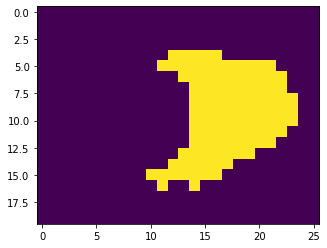

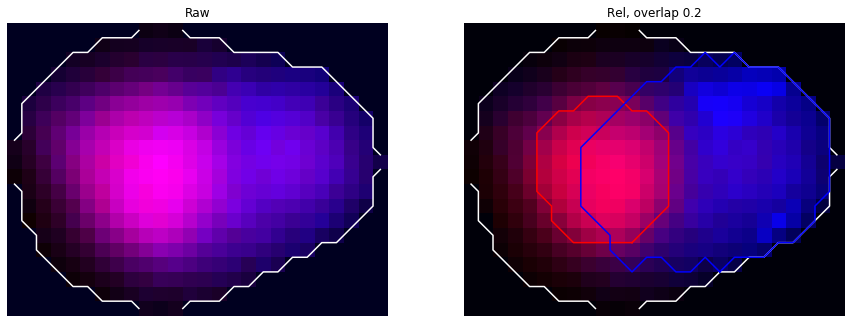

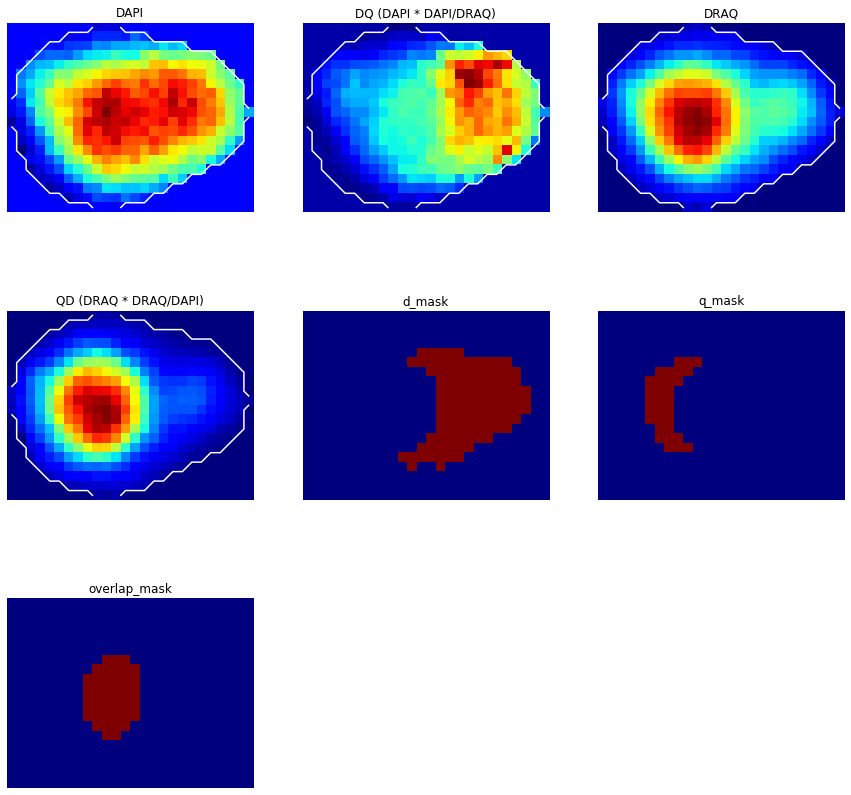

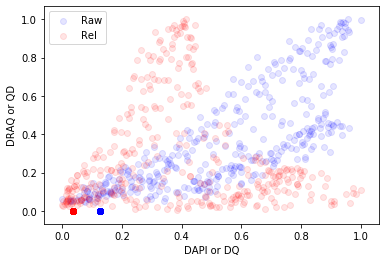

In [14]:
class OneCell():
    def __init__(self, cell_num:int,
                 dapi_img:np.ndarray, draq_img:np.ndarray, trans_img:np.ndarray,
                 cell_mask:np.ndarray,
                 overlap_threshold:float=0.1):
        self.cell_num = cell_num
        self.cell_species = 'NA'
        self.cell_mask = cell_mask
        self.cell_contour = measure.find_contours(self.cell_mask, level=0.5)  # mask contour for ctrl images
        self.zeros = np.zeros_like(self.cell_mask)  # zeros image for green channel in RGB images

        self.trans_img = trans_img

        self.dapi_img = np.float32(dapi_img)
        self.dapi_img = self.dapi_img - np.mean(self.dapi_img, where=~self.cell_mask)  # background extraction
        self.dapi_img[~self.cell_mask] = np.mean(self.dapi_img, where=~self.cell_mask)  # extracellular px masking

        self.draq_img = np.float32(draq_img)
        self.draq_img = self.draq_img - np.mean(self.draq_img, where=~self.cell_mask)  # background extraction - NO. (D)
        self.draq_img[~self.cell_mask] = np.mean(self.draq_img, where=~self.cell_mask)  # extracellular px masking

        self.scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), clip=True)  # naive 0-1 scaler, sensitive to outliers
        # self.scaler = preprocessing.RobustScaler(with_centering=True, with_scaling=True, quantile_range=(2.0, 98.0))

        self.dapi_norm = self.scaler.fit_transform(self.dapi_img.reshape(-1,1)).reshape(self.dapi_img.shape)
        self.draq_norm = self.scaler.fit_transform(self.draq_img.reshape(-1,1)).reshape(self.draq_img.shape)   
        self.raw_overlay = np.stack([self.draq_norm, self.zeros, self.dapi_norm], axis=-1)

        self.qd_rel = np.divide(self.draq_norm, self.dapi_norm, out=np.zeros_like(self.draq_norm), where=self.dapi_norm!=0)
        self.qd_rel = filters.median(self.qd_rel)
        self.qd = self.draq_img * self.qd_rel
        self.dq_rel = np.divide(self.dapi_norm, self.draq_norm, out=np.zeros_like(self.dapi_norm), where=self.draq_norm!=0)
        self.dq_rel = filters.median(self.dq_rel)
        self.dq = self.dapi_img * self.dq_rel

        self.qd_norm = self.scaler.fit_transform(self.qd.reshape(-1,1)).reshape(self.qd.shape)
        self.dq_norm = self.scaler.fit_transform(self.dq.reshape(-1,1)).reshape(self.dq.shape)
        self.rel_overlay = np.stack([self.qd_norm, self.zeros, self.dq_norm], axis=-1)

        # plt.imshow(np.digitize(self.draq_norm, bins=filters.threshold_multiotsu(self.draq_norm,classes = 3))) debug plot
        
        #the version that works for 13G - multiotsu with 3 classes for qd_mask
        self.qd_mask = morphology.opening(self.qd_norm > np.max(filters.threshold_multiotsu(self.qd_norm,classes = 3)))
        #plt.imshow(self.qd_mask) #debug plot
        
        self.dq_mask = morphology.opening(self.dq_norm > filters.threshold_otsu(self.dq_norm))       
        #old version
        #self.qd_mask = morphology.opening(self.qd_norm > filters.threshold_otsu(self.qd_norm))
        #self.dq_mask = morphology.opening(self.dq_norm > filters.threshold_otsu(self.dq_norm))

        
        self.q_mask = np.copy(self.qd_mask)
        self.q_mask[self.dq_mask] = False
        self.d_mask = np.zeros_like(self.dq_mask)
        #limiting kDNA mask to only the region that has *some higher than background* staining by DRAQ5 - to avoid incorporation of only-DAPI-stained-background
        self.d_mask[morphology.opening(self.draq_norm > np.unique(filters.threshold_multiotsu(self.draq_norm,classes = 3))[0])] = True 
        self.d_mask[self.qd_mask] = False #OLD
        self.d_mask[~self.dq_mask] = False
        plt.imshow(self.d_mask)

        self.overlap_mask = (self.qd_mask & self.dq_mask)
        #self.overlap_mask = (self.qd_mask & self.dq_mask) #OLD

        self.overlap_percent = np.sum((self.qd_mask & self.dq_mask)) / np.sum((self.qd_mask | self.dq_mask))
        
        
        #mean intensity of bg+cyt; counted before the overlapped masks get cut down
        self.no_feature = np.copy(self.draq_img)
        self.no_feature[self.q_mask.astype(np.bool)] = 0
        self.no_feature[self.d_mask.astype(np.bool)] = 0
        #print(np.mean(self.draq_img)) # -- control that bg+cyt are not taken into account! (uncomment for debug)
        #print(np.mean(self.no_feature)) # -- control that features are not taken into account! (uncomment for debug)
        #plt.imshow(self.no_feature) #debug plot
        print(self.overlap_percent)
        if self.overlap_percent <= 0.5 and self.overlap_percent >= 0.1 :
            self.if_overlapped = "TRUE"
            
            #cutting kDNA and nucleus masks to only non-overlap area
            self.d_mask[self.overlap_mask] = False
            self.q_mask[self.overlap_mask] = False
            ##now all same as before
            self.nucleus_raw_int = np.mean(self.draq_img, where=self.q_mask > 0)
            self.k_raw_int = np.mean(self.draq_img, where=self.d_mask > 0)
                ### Taking original DRAQ image, substractin mean of non-nucleus and non-kDNA intensity to normalise mean intensity of nucleus and kDNA
            self.nucleus_norm_int = self.nucleus_raw_int - (np.mean(self.no_feature, where=self.no_feature > 0))
            self.k_norm_int = self.k_raw_int - (np.mean(self.no_feature, where=self.no_feature > 0))
            #Assuming that the intensity of kDNA and nucleus are proportional to those of non-overlapped areas multiplied by the fraction of area that overlaps
            self.d_coefficient = np.sum(self.d_mask)/np.sum(self.overlap_mask)
            self.q_coefficient = np.sum(self.q_mask)/np.sum(self.overlap_mask)
            self.nucleus_norm_int = self.nucleus_norm_int + self.nucleus_norm_int*self.d_coefficient
            self.k_norm_int = self.k_norm_int + self.k_norm_int*self.q_coefficient
            
        if self.overlap_percent <= 0.1:
            self.if_overlapped = "FALSE"
            
            self.nucleus_raw_int = np.mean(self.draq_img, where=self.q_mask > 0)
            self.k_raw_int = np.mean(self.draq_img, where=self.d_mask > 0)
                ### Taking original DRAQ image, substractin mean of non-nucleus and non-kDNA intensity to normalise mean intensity of nucleus and kDNA
            self.nucleus_norm_int = self.nucleus_raw_int - (np.mean(self.no_feature, where=self.no_feature > 0))
            self.k_norm_int = self.k_raw_int - (np.mean(self.no_feature, where=self.no_feature > 0))
        
        if self.overlap_percent > 0.5:
            self.if_overlapped = "TRUE"
            self.nucleus_raw_int = 0
            self.k_raw_int = 0
                ### Taking original DRAQ image, substractin mean of non-nucleus and non-kDNA intensity to normalise mean intensity of nucleus and kDNA
            self.nucleus_norm_int = 0
            self.k_norm_int = 0
            
        print('nucleus/kDNA mean raw intensity' , self.nucleus_raw_int , self.k_raw_int)
        print('background+cytoplasm mean raw intensity')
        print(np.mean(self.no_feature, where=self.no_feature > 0))
        print('nucleus mean normalised intensity', self.nucleus_norm_int , ' kDNA mean normalised intensity ', self.k_norm_int)
    
    

    def pic_3d(self):
        xx, yy = np.mgrid[0:self.cell_mask.shape[0], 0:self.cell_mask.shape[1]]

        import plotly.graph_objects as go
        from plotly.offline import iplot

        data = [go.Surface(x=xx,y=yy,z=self.draq_norm,
                        colorscale='Reds', opacity=0.65, showscale=False),
                go.Surface(x=xx,y=yy,z=self.dapi_norm,
                        colorscale='Blues', opacity=0.65, showscale=False)]
        iplot(data)


    def pic_grid(self):
        plt.figure(figsize=(15,15))

        ax0 = plt.subplot(334)
        ax0.imshow(self.qd_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax0.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax0.set_title('QD (DRAQ * DRAQ/DAPI)')
        ax0.axis('off')

        ax2 = plt.subplot(333)
        ax2.imshow(self.draq_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax2.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax2.set_title('DRAQ')
        ax2.axis('off')

        ax1 = plt.subplot(332)
        ax1.imshow(self.dq_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax1.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax1.set_title('DQ (DAPI * DAPI/DRAQ)')
        ax1.axis('off')

        ax3 = plt.subplot(331)
        ax3.imshow(self.dapi_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax3.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax3.set_title('DAPI')
        ax3.axis('off')
        
        ax4 = plt.subplot(335)
        ax4.imshow(self.d_mask, cmap='jet')
        ax4.set_title('d_mask')
        ax4.axis('off')
                
        ax4 = plt.subplot(336)
        ax4.imshow(self.q_mask, cmap='jet')
        ax4.set_title('q_mask')
        ax4.axis('off')
        
        ax5 = plt.subplot(337)
        ax5.imshow(self.overlap_mask, cmap='jet')
        ax5.set_title('overlap_mask')
        ax5.axis('off')
        
        plt.show()


    def pic_overlay(self):
        self.qd_contour = measure.find_contours(self.qd_mask, level=0.5)
        self.dq_contour = measure.find_contours(self.dq_mask, level=0.5)

        plt.figure(figsize=(15,15))

        ax0 = plt.subplot(121)
        ax0.imshow(self.raw_overlay)
        for ce_c in self.cell_contour:
            ax0.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax0.set_title('Raw')
        ax0.axis('off')

        ax2 = plt.subplot(122)
        ax2.imshow(self.rel_overlay)
        for ce_c in self.cell_contour:
            ax2.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        for qd_c in self.qd_contour:
            ax2.plot(qd_c[:, 1], qd_c[:, 0], linewidth=1.5, color='r')
        for dq_c in self.dq_contour:
            ax2.plot(dq_c[:, 1], dq_c[:, 0], linewidth=1.5, color='b')
        ax2.set_title(f'Rel, overlap {round(self.overlap_percent, 2)}')
        ax2.axis('off')

    
    def pic_px_plot(self):
        plt.scatter(self.dapi_norm.ravel(), self.draq_norm.ravel(),
            color='b', alpha=.1, label='Raw')
        plt.scatter(self.dq_norm.ravel(), self.qd_norm.ravel(),
                    color='r', alpha=.1, label='Rel')
        plt.xlabel('DAPI or DQ')
        plt.ylabel('DRAQ or QD')
        plt.legend()
        plt.show()


for region in measure.regionprops(cells_labels):
    if region.label == 1:  # 9, 10
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=2)
        demo_cell = OneCell(cell_num=region.label,
                            dapi_img=img_dapi[minr:maxr, minc:maxc],
                            draq_img=img_draq[minr:maxr, minc:maxc],
                            trans_img=img_trans[minr:maxr, minc:maxc],
                            cell_mask=fin_fluo_mask[minr:maxr, minc:maxc])
        
demo_cell.pic_overlay()
demo_cell.pic_grid()
demo_cell.pic_px_plot()

In [20]:
list_of_tiffs = os.listdir('/media/dzavadska/Elements/kineto_firstadequate_sample_set_Nov_2023')
print(list_of_tiffs[0])

np.isin(np.array(list_of_tiffs), np.array('thickstack'))

list_of_tiffs_annotated = [s for s in list_of_tiffs if 'thickstack' in s]
list_of_tiffs_annotated = [s for s in list_of_tiffs_annotated if '13G' in s]
#list_of_tiffs_annotated = [s for s in list_of_tiffs_annotated if 'slice' not in s]
#list_of_tiffs_annotated = [s for s in list_of_tiffs_annotated if 'thinstack' not in s]
print(len(list_of_tiffs_annotated))

#list_of_tiffs_annotated = list_of_tiffs_annotated[29:34]
print(list_of_tiffs_annotated[1])

13G_Diplo_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-06(12).tif
10
13G_Capsa_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-02.tif


13G_Capsa_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-02.tif


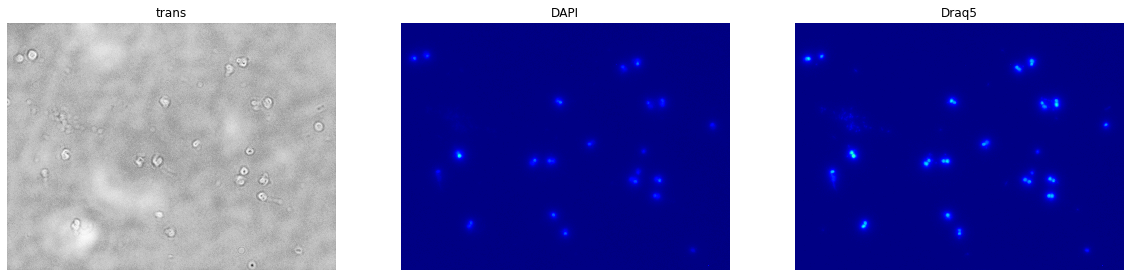

/home/dzavadska/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


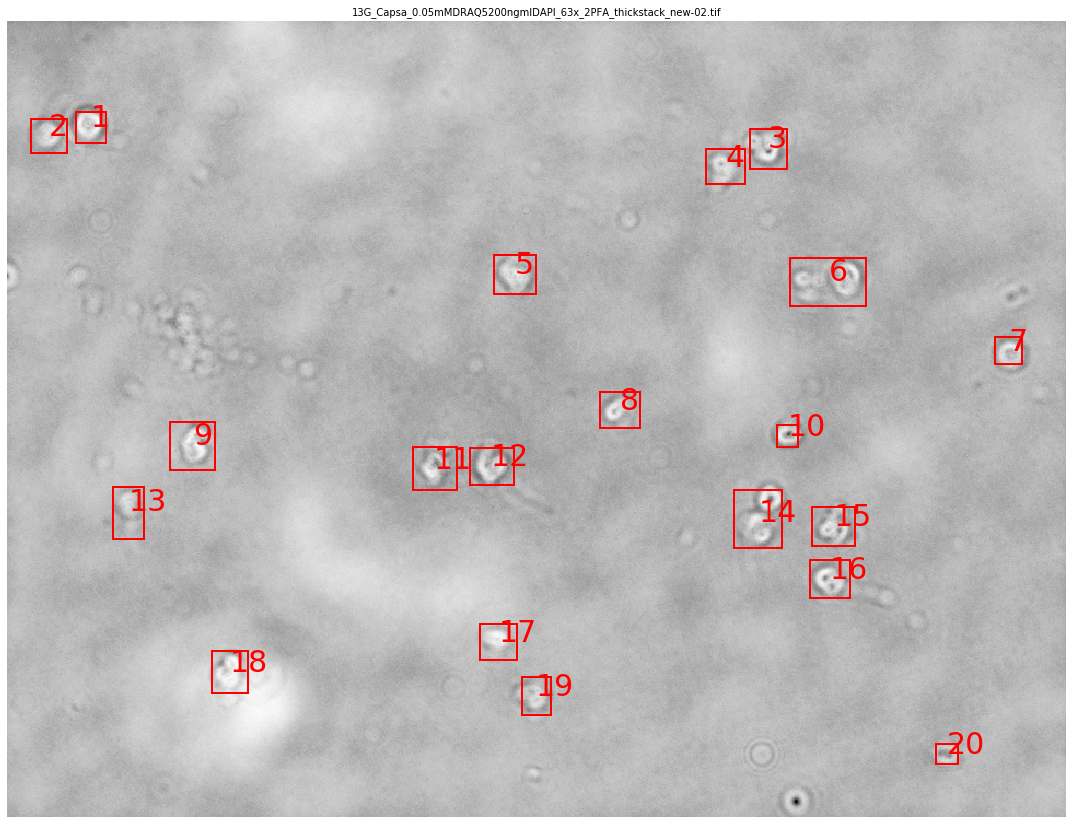

/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.10067114093959731
nucleus/kDNA mean raw intensity 19884.148 10500.557
background+cytoplasm mean raw intensity
5354.609
nucleus mean normalised intensity 67804.515625  kDNA mean normalised intensity  11149.553466796875


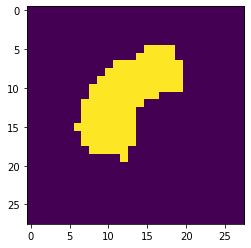

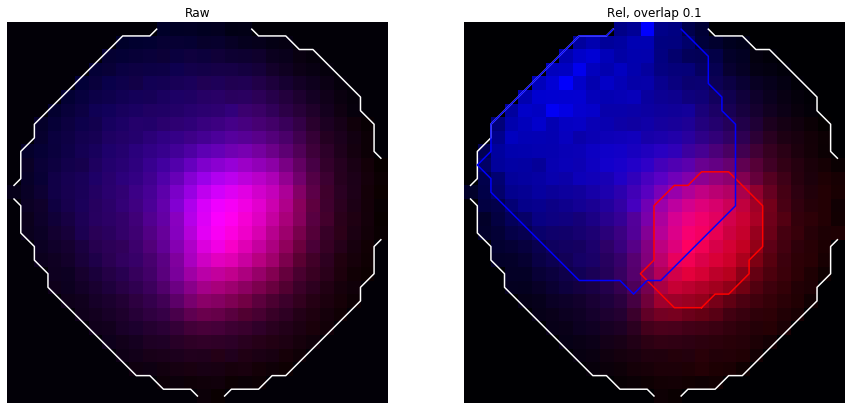

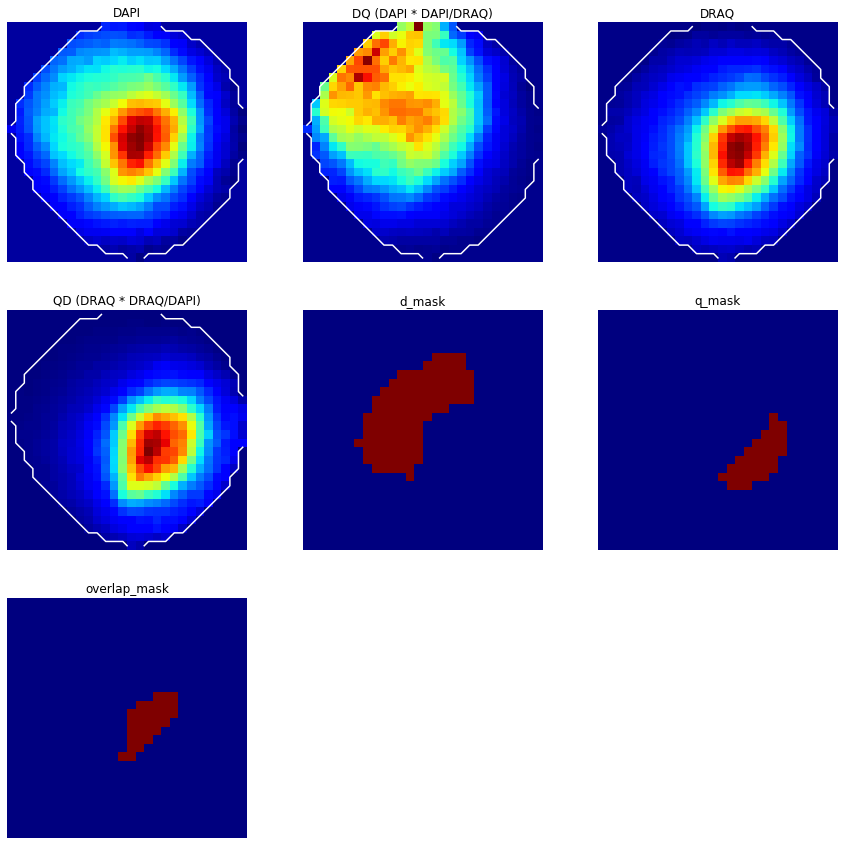

T/C/S:   C


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.3407079646017699
nucleus/kDNA mean raw intensity 22012.613 16378.098
background+cytoplasm mean raw intensity
8836.264
nucleus mean normalised intensity 23443.635019277597  kDNA mean normalised intensity  15867.235135957793


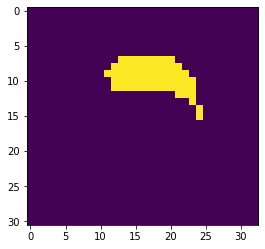

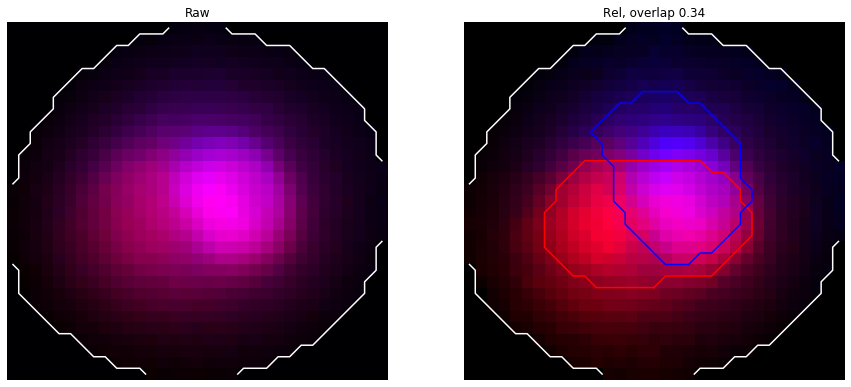

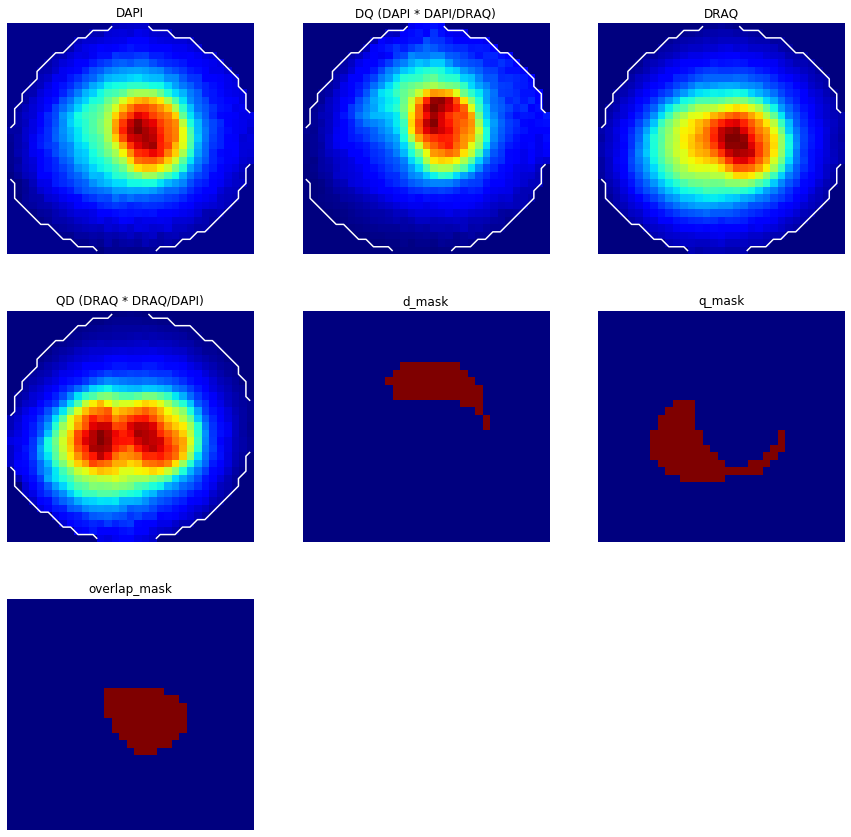

T/C/S:   T


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.2565217391304348
nucleus/kDNA mean raw intensity 25630.998 21324.717
background+cytoplasm mean raw intensity
8077.1157
nucleus mean normalised intensity 38975.5703125  kDNA mean normalised intensity  35476.62791313559


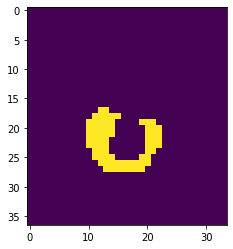

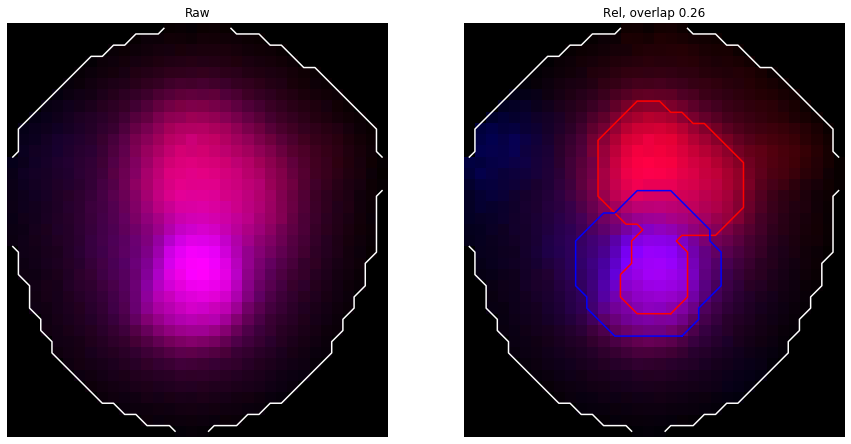

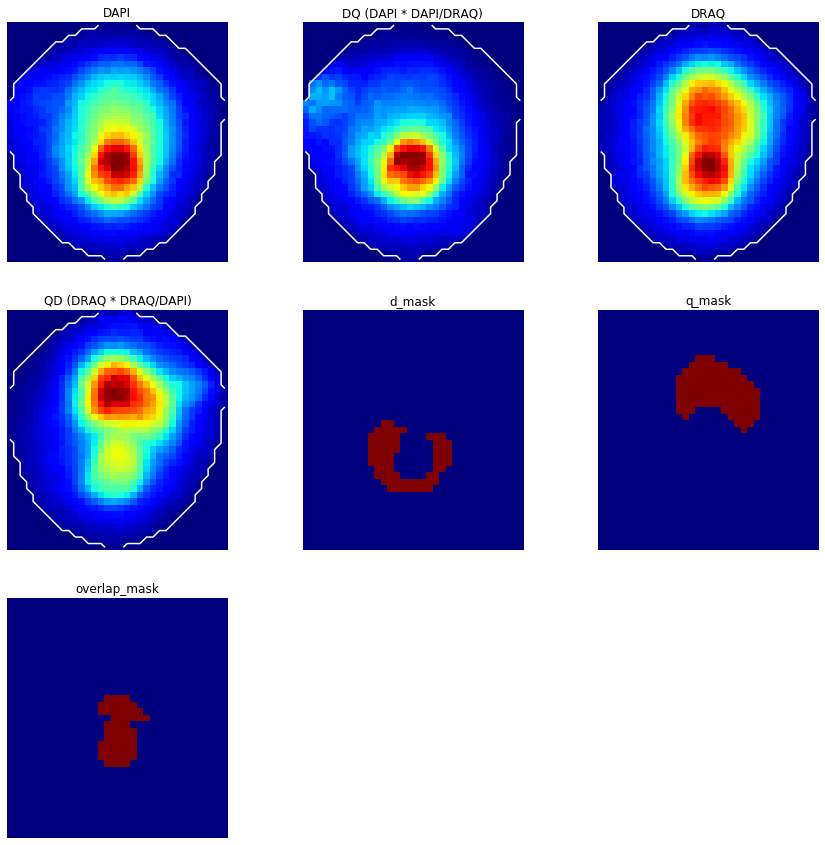

T/C/S:   S


fuck it
0.21888412017167383
nucleus/kDNA mean raw intensity 22904.14 17625.215
background+cytoplasm mean raw intensity
7354.7017
nucleus mean normalised intensity 45123.86351102941  kDNA mean normalised intensity  27388.036458333336


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


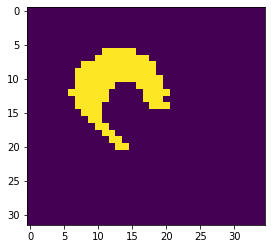

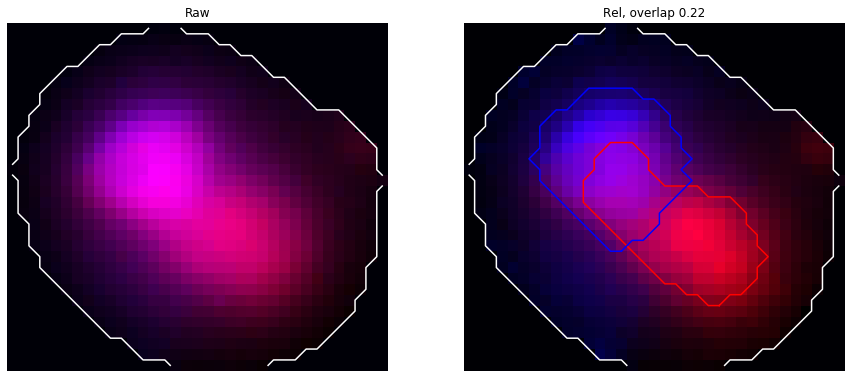

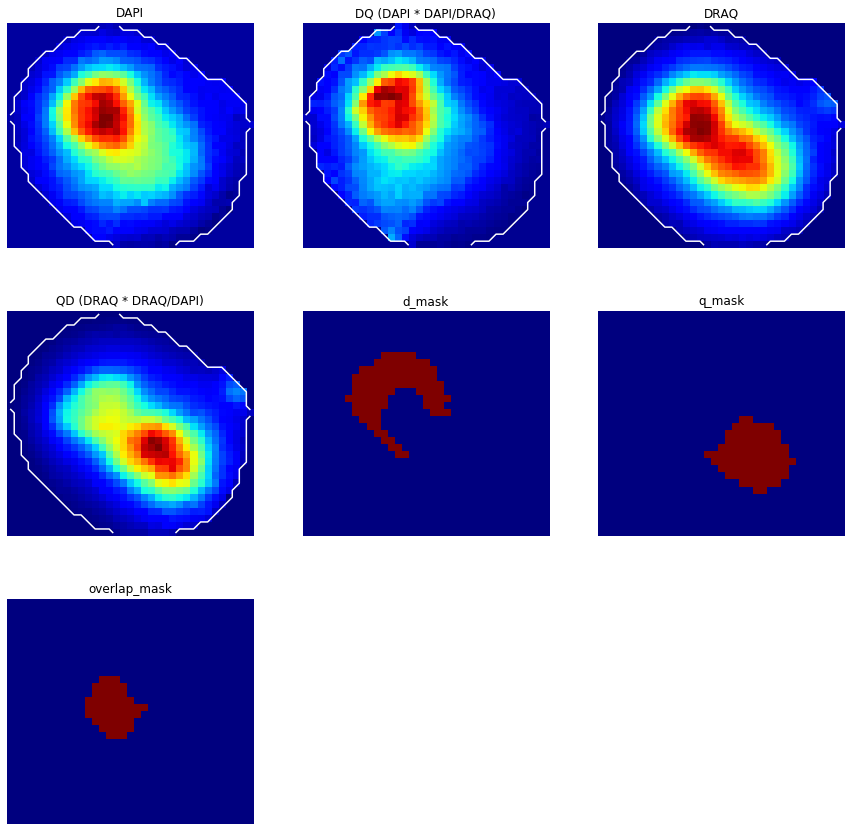

T/C/S:   S


fuck it
0.13618677042801555
nucleus/kDNA mean raw intensity 30754.188 20562.09
background+cytoplasm mean raw intensity
7767.1123
nucleus mean normalised intensity 142519.86015625  kDNA mean normalised intensity  27417.809012276783


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


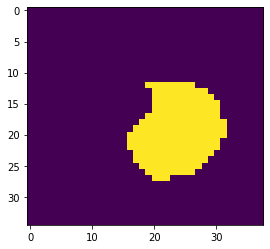

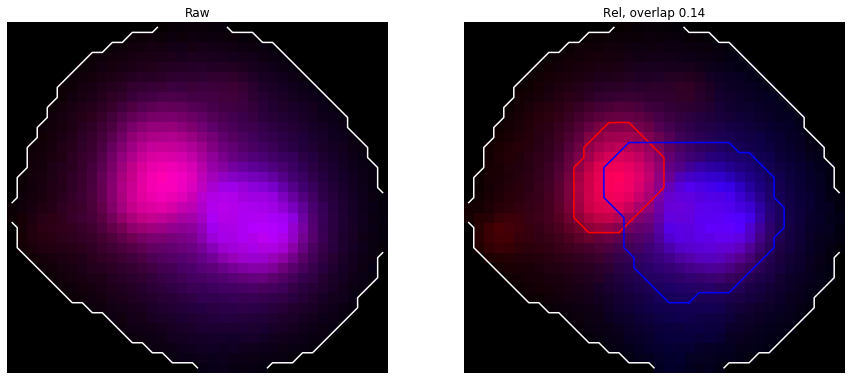

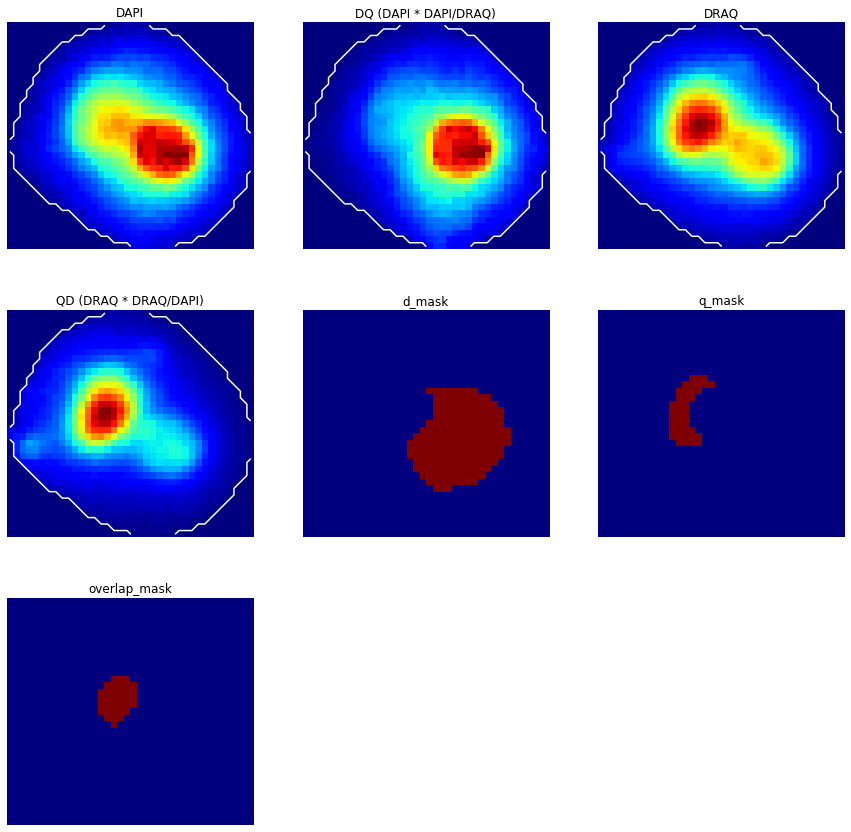

T/C/S:   S


fuck it
0.1134020618556701
nucleus/kDNA mean raw intensity 24613.459 18337.307
background+cytoplasm mean raw intensity
4809.8804
nucleus mean normalised intensity 141196.94013798703  kDNA mean normalised intensity  30568.46864853896


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


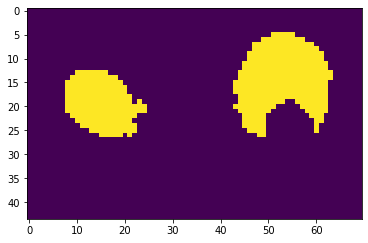

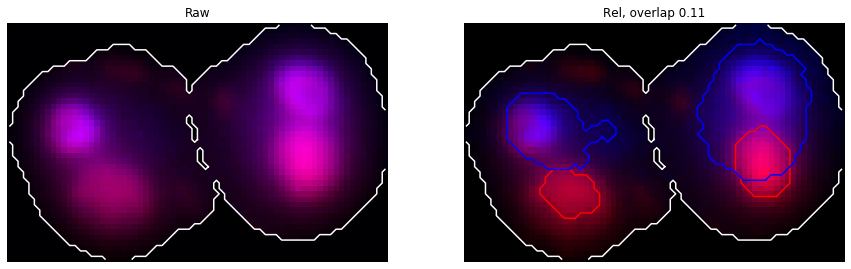

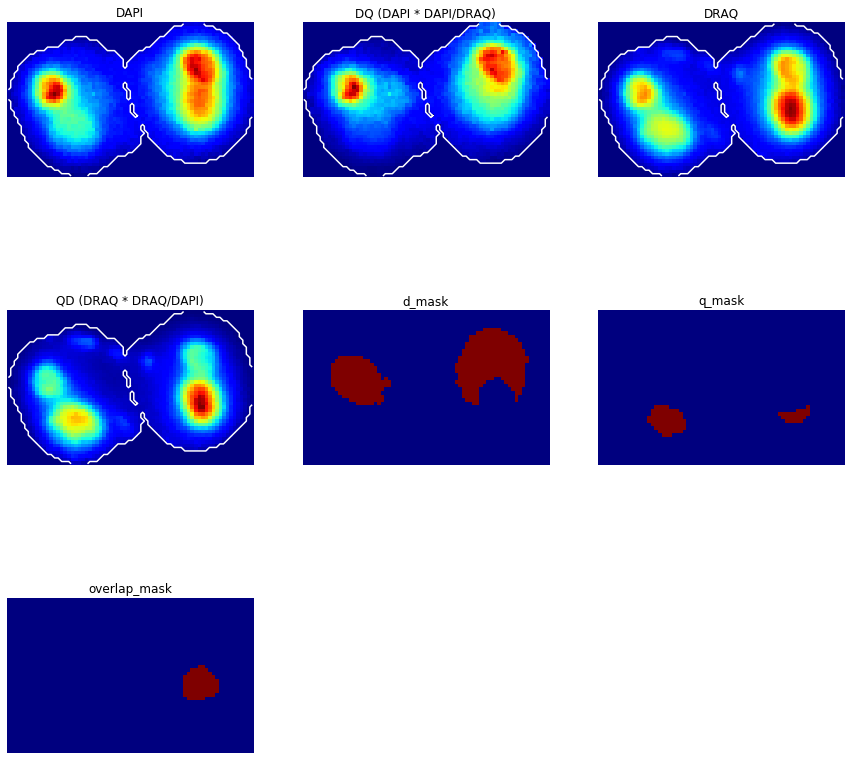

T/C/S:   S


fuck it
0.23371647509578544
nucleus/kDNA mean raw intensity nan 11249.75
background+cytoplasm mean raw intensity
4924.1846
nucleus mean normalised intensity nan  kDNA mean normalised intensity  6325.5654296875


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0
/home/dzavadska/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:343

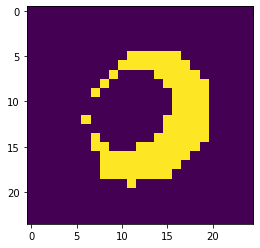

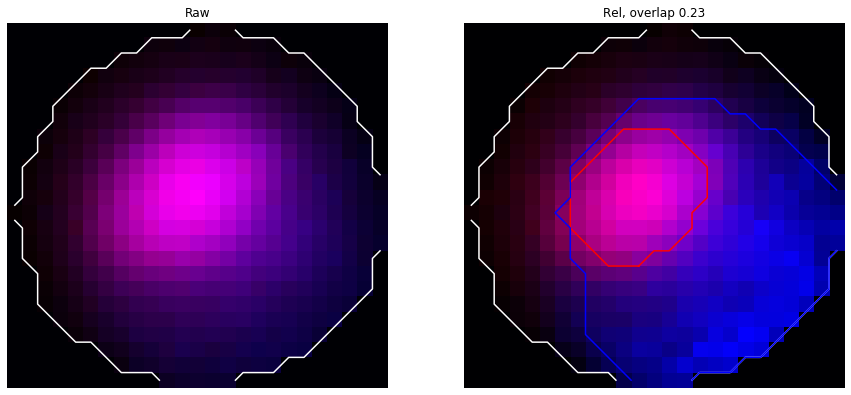

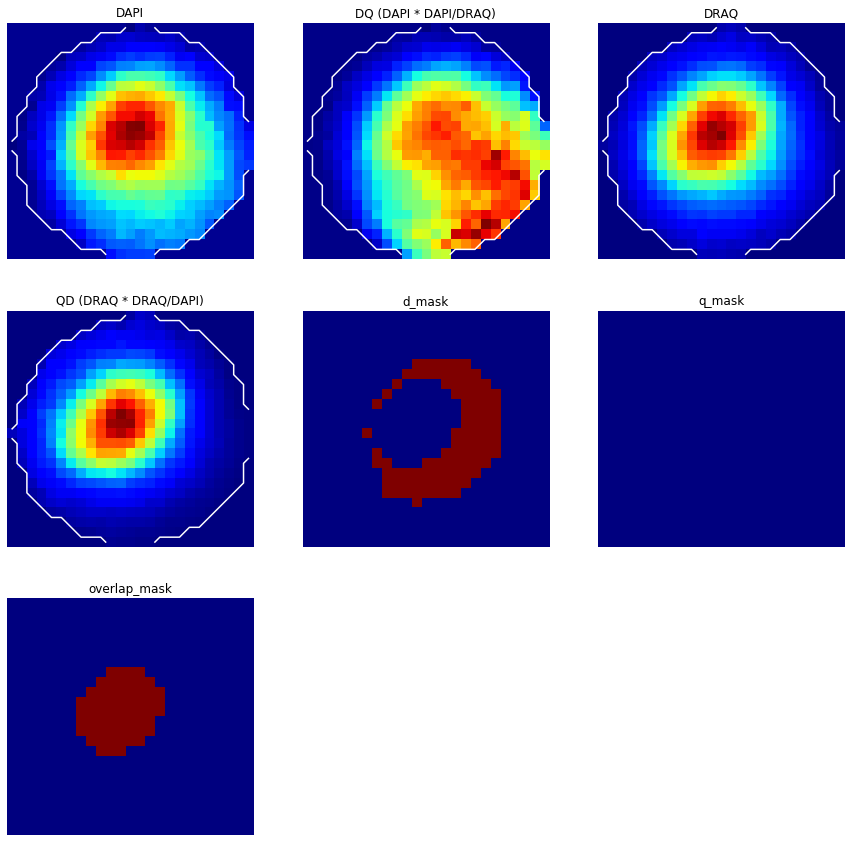

T/C/S:   C


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


0.21875
nucleus/kDNA mean raw intensity 18341.135 16391.564
background+cytoplasm mean raw intensity
5039.377
nucleus mean normalised intensity 29348.322792658728  kDNA mean normalised intensity  38201.01190476191


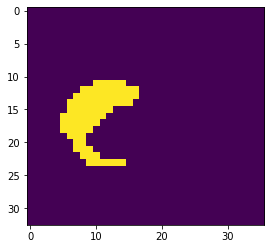

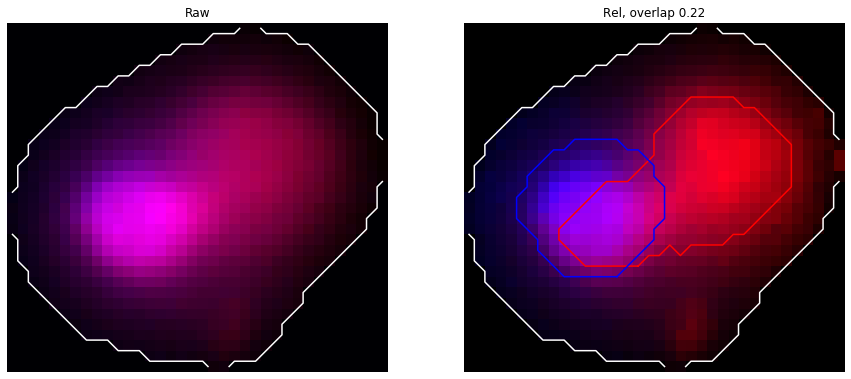

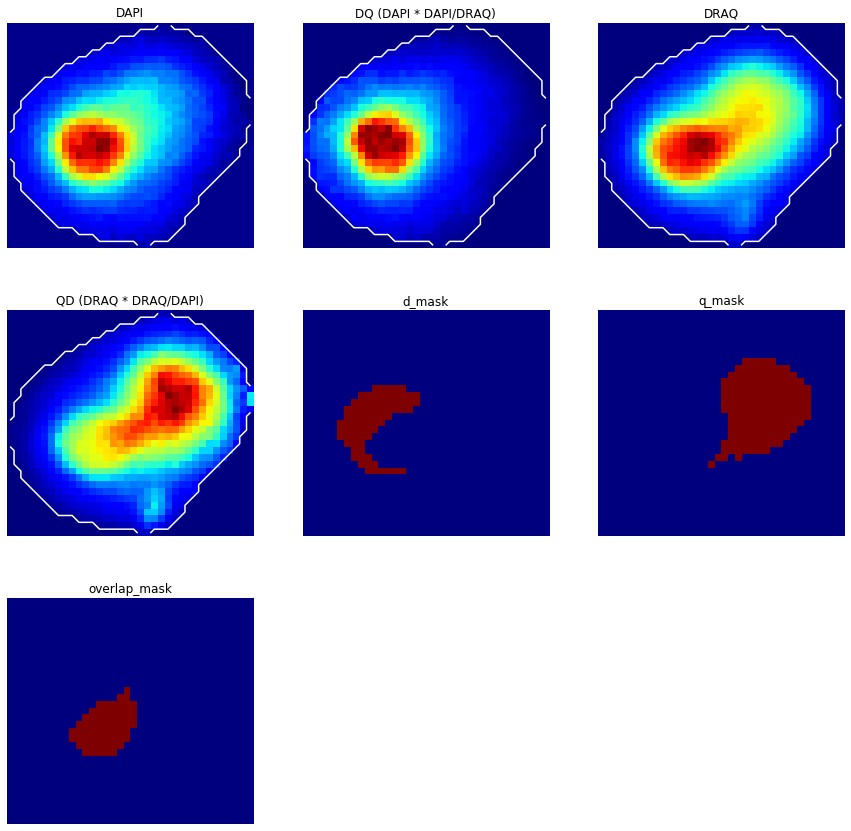

T/C/S:   S


fuck it
0.25
nucleus/kDNA mean raw intensity 35221.95 28343.598
background+cytoplasm mean raw intensity
9619.5
nucleus mean normalised intensity 67531.09793931158  kDNA mean normalised intensity  44232.28866621377


/tmp/ipykernel_100087/3704336437.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.q_mask.astype(np.bool)] = 0
/tmp/ipykernel_100087/3704336437.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.d_mask.astype(np.bool)] = 0


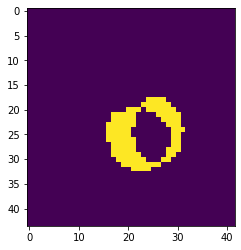

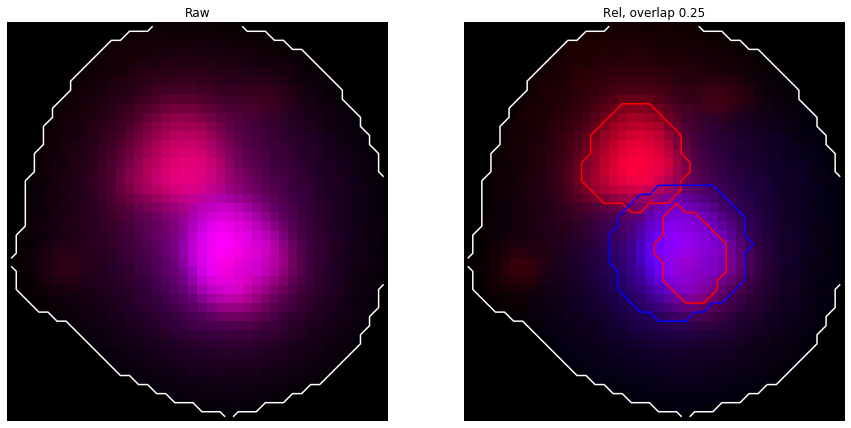

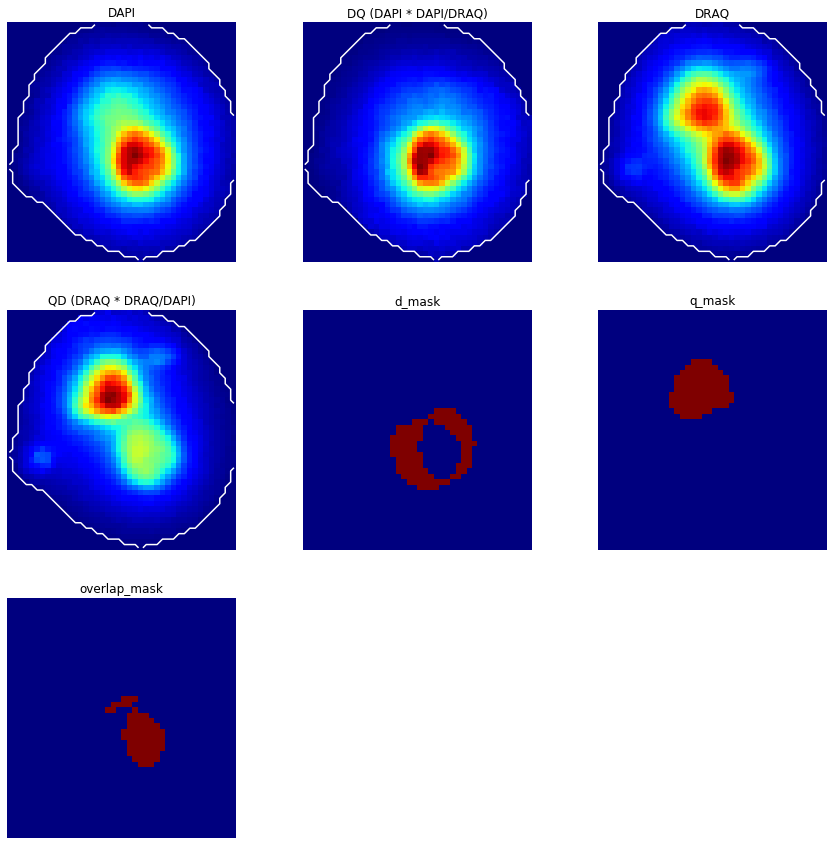

KeyboardInterrupt: Interrupted by user

In [25]:
fin_out_df = pd.DataFrame(columns=['img_name',
                                   'num',
                                  'species',
                                  'cell_area',
                                  'kDNA_int',
                                  'kDNA_area',
                                  'nDNA_int',
                                  'nDNA_area'])

for tiff in list_of_tiffs_annotated[1:9] :
#######Reading image
    print(tiff)
    img_raw = io.imread("/media/dzavadska/Elements/kineto_firstadequate_sample_set_Nov_2023/" + str(tiff))
    img_ch0 = img_raw[:,:,:,0]
    img_ch1 = img_raw[:,:,:,1]
    img_ch2 = img_raw[:,:,:,2]

    img_trans = np.mean(img_ch0, axis=0)
    img_dapi = np.sum(img_ch2, axis=0, dtype='int64')
    img_draq = np.sum(img_ch1, axis=0, dtype='int64')

    plt.figure(figsize=(20,20))
    plt.title(tiff, fontsize=10)
    
    ax0 = plt.subplot(132)
    ax0.imshow(img_dapi, cmap='jet')
    ax0.set_title('DAPI')
    ax0.axis('off')

    ax1 = plt.subplot(131)
    ax1.imshow(img_trans, cmap='Greys')
    ax1.set_title('trans')
    ax1.axis('off')

    ax2 = plt.subplot(133)
    ax2.imshow(img_draq, cmap='jet')
    ax2.set_title('Draq5')
    ax2.axis('off')

    plt.show()
##############Selecting cells
# masking by trans img
    img_trans_filt = filters.gaussian(img_trans, sigma=2)

    img_trans_filt = img_trans_filt / np.max(np.abs(img_trans_filt))
    img_trans_filt = filters.rank.gradient(img_trans_filt, morphology.disk(3))

    mask = img_trans_filt > filters.threshold_otsu(img_trans_filt)
    mask = ndi.binary_fill_holes(mask)
    mask = segmentation.clear_border(mask)

    mask = morphology.erosion(mask, footprint=morphology.disk(5))
    mask = morphology.dilation(mask, footprint=morphology.disk(4))
    
    labels, labels_num = ndi.label(mask)

# debris filtering
    ctrl_fluo_img = img_dapi + img_draq
    ctrl_fluo_mask = ctrl_fluo_img > filters.threshold_otsu(ctrl_fluo_img)

    sums = ndi.sum(ctrl_fluo_mask, labels, np.arange(labels_num+1))
    connected = sums > 0
    debris_mask = connected[labels]

# final mask filtering
    fin_trans_mask = np.copy(mask)
    fin_trans_mask[~debris_mask] = 0  # debris rejection
# fin_trans_mask[ctrl_fluo_mask] = 1  # holes filling with DAPI+DRAQ mask
# fin_trans_mask = segmentation.clear_border(fin_trans_mask)  # borders cleaning
# fin_trans_mask = morphology.opening(fin_trans_mask, footprint=morphology.disk(5))  # rejection of DAPI+DRAW mask artifacts
# fin_trans_mask = ndi.binary_fill_holes(fin_trans_mask)

    fin_fluo_mask = morphology.dilation(ctrl_fluo_mask, footprint=morphology.disk(4))
    fin_fluo_mask = segmentation.clear_border(fin_fluo_mask)
    fin_fluo_mask = morphology.opening(fin_fluo_mask, footprint=morphology.disk(6))  # rejection of DAPI+DRAW mask artifacts

    cells_labels, cells_num = ndi.label(fin_fluo_mask)


# plt.figure(figsize=(20,20))

# ax1 = plt.subplot()
# ax1.imshow(img_trans, cmap='Greys')
# ax1.imshow(ma.masked_where(~fin_trans_mask, cells_labels), cmap='jet', alpha=.5)
# ax1.imshow(ma.masked_where(~fin_fluo_mask, fin_fluo_mask), cmap='Greys', alpha=.4)
# ax1.imshow(ma.masked_where(debris_mask, ~debris_mask), cmap='magma', alpha=.75)
# ax1.axis('off')
# ax1.set_title(f'DNA-containing elements selection ({cells_num} cells)\nwhite - DAPI+DRAQ regions, black - debris',
#               fontsize=30)

# plt.tight_layout()
# plt.show()

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_trans, cmap='Greys')
    ax.set_axis_off()
    ax.set_title('Cells regions')

    for region in measure.regionprops(cells_labels):
    # if region.label == 3:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(region.centroid[1], region.centroid[0], region.label, color='red', fontsize=30)

    plt.title(tiff, fontsize=10)
    plt.tight_layout()
    plt.show()
    
    
    
    
    
    #for each region, calculating parameters
    cells_list = []
    for region in measure.regionprops(cells_labels):
    #    if region.label == 1:  # uncomment for debug
        minr, minc, maxr, maxc = region.bbox
        some_cell = OneCell(cell_num=region.label,
                            dapi_img=img_dapi[minr:maxr, minc:maxc],
                            draq_img=img_draq[minr:maxr, minc:maxc],
                            trans_img=img_trans[minr:maxr, minc:maxc],
                            cell_mask=fin_fluo_mask[minr:maxr, minc:maxc])
        
        some_cell.pic_overlay()
        some_cell.pic_grid()
        check = input('T/C/S:  ')
        if check == 'S':
            print("fuck it")
            some_cell.cell_species = "Some_shit"
        elif check == 'C':
            cells_list.append(some_cell)
            some_cell.cell_species = "Control"
        elif check == 'T':
            cells_list.append(some_cell)
            some_cell.cell_species = "Test"      
        
        
    #demo_cell.pic_px_plot()

    for cell in cells_list:
        cell_df = cell.calc_cell_parameters()

        output_df = pd.concat([output_df, cell_df],
                               ignore_index=True)
    
    
  
    # Using 'Address' as the column name
    
    
    
    # and equating it to the list
    output_df['img_name'] = tiff
    
    
    fin_out_df = pd.concat([fin_out_df, output_df])
    fin_out_df.to_csv('/home/dzavadska/Data/kDNA/fluo_methods/scripts2024/run_outs_tmp/12012024_demo12012024_firstlooprun.csv')

